In [1]:
# Import some libraries we'll need
import underworld as uw
import glucifer
import numpy
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

uw.matplotlib_inline()

### Groundwater Flow Induced by Topography

The darcy flow solver, ``uw.systems.SteadyStateDarcyFlow``, can solve for ground-water flow induced by an imposed pressure-gradient and/or a gravity term. In this example we show how groundwater flow beneath hetereogeneous topography can be modelled in each of these two ways.

If the gravity term is included, then a deformed mesh which captures topography will drive groundwater flow.
Without the gravity term, a pressure boundary condition can be set at the top of an undeformed mesh, which mimics the change in groundwater pressure induced by topography.

Classic models of groundwater flow in a hill-side with undulating topography were solved analytically in Toth. J, *A Theoretical Analysis of Groundwater Flow in Small Drainage Basins*, Journal of Geophysical Research, 1963. Their simple model is reproduced here, particularly the geometry in their Fig. 2e.

---
Whether or not to model topography with a deformed mesh. If set to true, the gravity term is included. Otherwise, the upper modified pressure BC is used.

In [2]:
deformedmesh = True

---

*Set up mesh and fields*

In [3]:

elementType = "Q1"
resX = 256
resY = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (0., -1.), 
                                 maxCoord    = (4., 0.)) 

gwPressureField    = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField    = mesh.add_variable( nodeDofCount=1 )
velocityField = mesh.add_variable(nodeDofCount=2)

Pick topography geometry. This is based on Toth (1963) Fig. 2e. 

In [4]:
# Set up topography
hillsize = 0.2


# pick depth above which to deform mesh
ydeform = -0.5

yCoordFn = uw.function.input()[1]
xCoordFn = uw.function.input()[0]

# ramp option
ydel = hillsize  * (xCoordFn )/4. + 0.04 * uw.function.math.sin(xCoordFn * 2. * 3.141)

if deformedmesh:
    with mesh.deform_mesh():
        for i in range(len(mesh.data[:])):
            y = mesh.data[i,1]
            if y >= ydeform:
                delY = ydel.evaluate((mesh.data[i,0],mesh.data[i,1])) #0.1 * (mesh.data[i,0] + 1.)/2.
                dY = (y - ydeform)/(-ydeform) * delY

                mesh.data[i,1] += dY



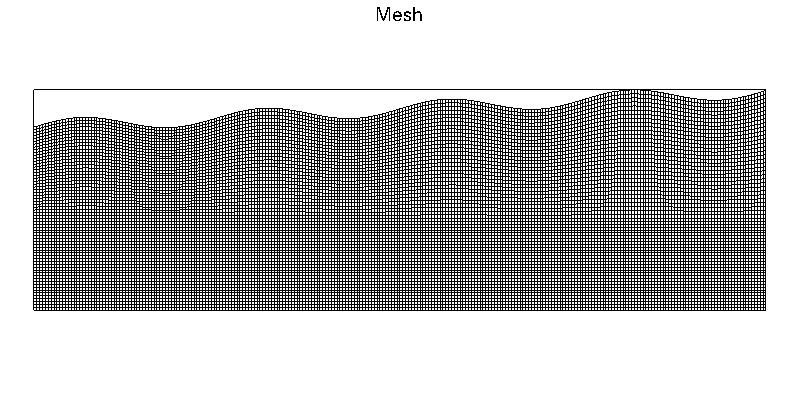

In [5]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Mesh" )
figMaterial.append( glucifer.objects.Mesh(mesh))

figMaterial.show()



*Set up the types of boundary conditions*
We'll set the left, right and bottom walls such that flow cannot pass through them, only parallel.
In other words for groundwater pressure $P$:

$ \frac{\partial P}{\partial x}=0$ : left and right walls

$ \frac{\partial P}{\partial y}=0$ : bottom wall

This is only solvable if there is topography or a non-uniform upper pressure BC.

In [6]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

# insideNodes = []
# for i in range(mesh.nodesLocal):
#     if i not in iWalls and i not in jWalls:
#         insideNodes.append(i)




gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
                                               indexSetsPerDof = ( topWall   ) )



*Set initial conditions and the values of the boundary conditions. Because the upper BC is a dirichlet condition, the upper wall is constrained to the value we set now. For the rest of the domain, it is helpful to set an increasing groundwater pressure gradient, but the values will be changed during the solution.*

In [7]:
#Lower groundwater pressure boundary condition
#    this value is relative to gravity
maxgwpressure = 0.9

if deformedmesh:
    initialFn = -1. * ( yCoordFn - ydel) / (1.+ydel)
else:
    initialFn = ydel -(yCoordFn)*(1.+ydel) 

initialFn = initialFn * maxgwpressure
gwPressureField.data[:] = initialFn.evaluate(mesh)




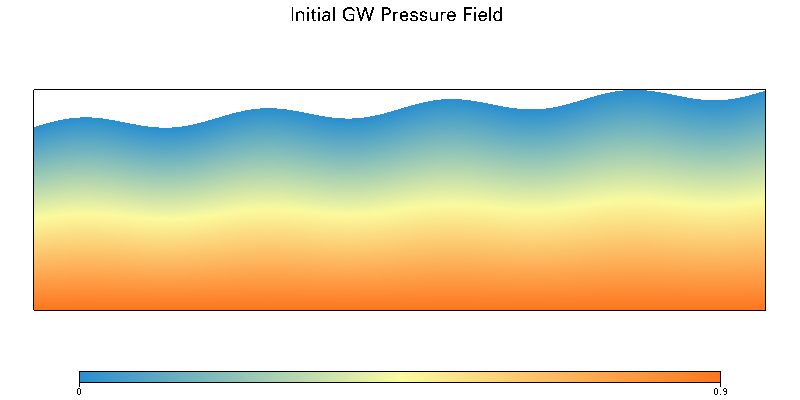

In [8]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Initial GW Pressure Field" )
figMaterial.append( glucifer.objects.Surface(mesh,gwPressureField,onMesh=True ))

figMaterial.show()


*Set up swarm. It is best to set only one particle per cell, to prevent variations in hydaulic diffusivity within cells.* 

In [9]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=1)
swarm.populate_using_layout( layout=swarmLayout )



*Assign materials to particles.* A material called ``materialImpermeable`` has been set up in the lower half of the domain, so you can later experiment with setting an impermeable basement.

In [10]:
materialIndex  = swarm.add_variable( dataType="int",    count=1 )
swarmVelocity  = swarm.add_variable( dataType="double",    count=2 )


materialPorous        = 0
materialImpermeable   = 1

xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

conditions = [ (yCoordFn > -0.5, materialPorous),
                ( xCoordFn < -1. , materialPorous),
               ( True , materialImpermeable )]


materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)



For now, the hydraulic diffusivity is identical for the top and bottom materials. Make Kb small if you want to set an impermeable basement.

In [11]:
Ka = 1.
Kb = 1.

hydraulicDiffusivityMap = { materialPorous : Ka, 
                 materialImpermeable : Kb}
hydraulicDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = hydraulicDiffusivityMap )

if deformedmesh:
    g = uw.function.misc.constant((0.,-1.))
else:
    g = uw.function.misc.constant((0.,0.))

hydproj = uw.utils.MeshVariable_Projection(hydraulicDiffusivityField,hydraulicDiffusivityMapFn,swarm)
hydproj.solve()




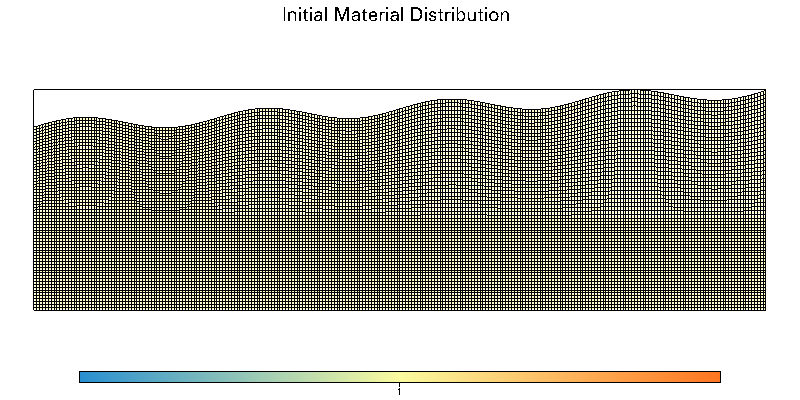

In [12]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Initial Material Distribution" )
figMaterial.append( glucifer.objects.Points(swarm, hydraulicDiffusivityMapFn, pointSize=2.0) )

figMaterial.append( glucifer.objects.Mesh(mesh))
figMaterial.show()

*Setup groundwater equations*

In [13]:
Storage = 1.

rho_water = 1.


gwPressureGrad = gwPressureField.fn_gradient

gMapFn = -g * rho_water * Storage
gwadvDiff = uw.systems.SteadyStateDarcyFlow( velocityField=velocityField,pressureField = gwPressureField, 
                                            fn_diffusivity = hydraulicDiffusivityMapFn,conditions=[gwPressureBC],
                                            fn_bodyforce=-gMapFn,voronoi_swarm=swarm,swarmVarVelocity=swarmVelocity)


gwsolver = uw.systems.Solver(gwadvDiff)



In [14]:
gwsolver.solve()



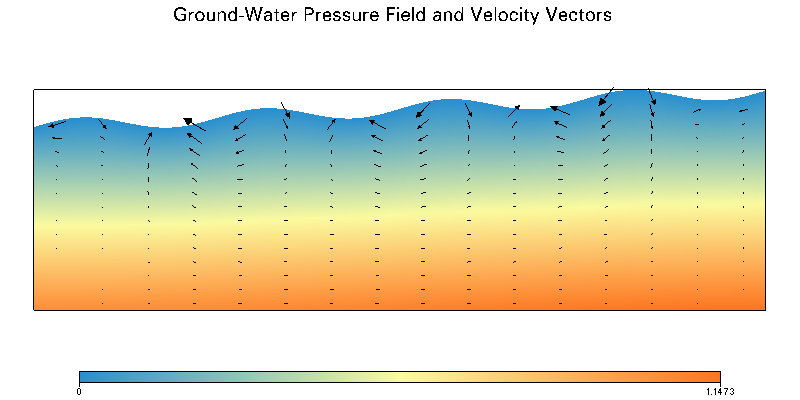

In [15]:
figMaterial = glucifer.Figure( figsize=(800,400),title="Ground-Water Pressure Field and Velocity Vectors" )
figMaterial.append(glucifer.objects.Surface(mesh,gwPressureField,onMesh=True))
scale = 0.03
figMaterial.append(glucifer.objects.VectorArrows(mesh,velocityField,scaling=0.5,arrowHead=0.3))
figMaterial.show()


*Use matplotlib to plot pressure contours and stream-lines, to produce a similar type of figure to Toth (1963).*


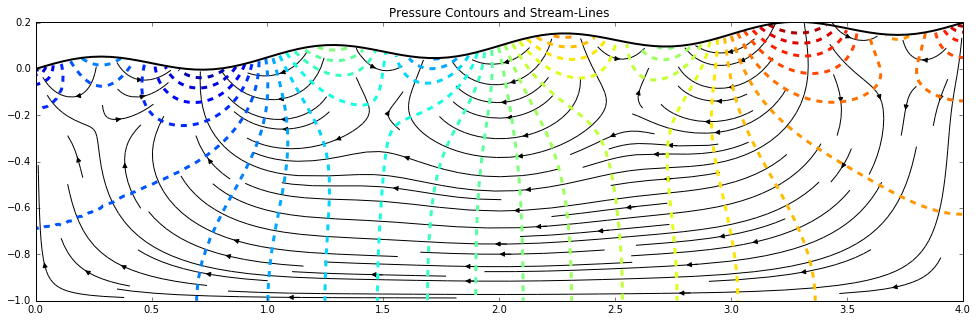

In [18]:
# If in parallel, this will only plot the data from one CPU. If you would like to make the same plot in parallel, you
#     should save the data, then do this as a post-processing step. 

if uw.rank() == 0:
    if deformedmesh:
        gravterm = 1.
    else:
        gravterm = 0.


    arrXi = numpy.linspace(0,4,400)
    if deformedmesh:
        maxY = numpy.max(mesh.data[:,1])
    else:
        maxY = 0.

    arrYi = numpy.linspace(-1,maxY,100)

    maskArray = numpy.ones((len(arrXi),len(arrYi)))
    for i in range(len(arrXi)):
        for j in range(len(arrYi)):
            if arrYi[j] < ydel.evaluate(numpy.array([[arrXi[i],arrYi[j]]])):
                maskArray[i,j] = 0.

    arrX, arrY = numpy.meshgrid(arrXi, arrYi)
    arrP = griddata(mesh.data[:,0], mesh.data[:,1], gwPressureField.data[:,0] + gravterm*mesh.data[:,1], arrX, arrY,interp="linear").T

    arrP = numpy.ma.array(arrP,mask=maskArray)


    plt.figure(figsize=(20,5))
    plt.gca().set_aspect('equal')

    nLevels = 25
    levels = numpy.linspace(numpy.min(arrP),numpy.max(arrP),nLevels)
    plt.contour(arrX,arrY,arrP.T,levels=levels,linewidths=numpy.ones(nLevels)*3,linestyles="dashed")

    hillX = numpy.linspace(0,4,100)
    hillY = ydel.evaluate(numpy.vstack([hillX,numpy.zeros(100)]).T)
    plt.plot(hillX,hillY,c="black",lw=2)

    arrU = griddata(swarm.particleCoordinates.data[:,0], swarm.particleCoordinates.data[:,1], swarmVelocity.data[:,0], arrX, arrY,interp="linear").T
    arrV = griddata(swarm.particleCoordinates.data[:,0], swarm.particleCoordinates.data[:,1], swarmVelocity.data[:,1], arrX, arrY,interp="linear").T

    arrU = numpy.ma.array(arrU,mask=maskArray)
    arrP = numpy.ma.array(arrP,mask=maskArray)
    plt.streamplot(arrXi,arrYi,arrU.T,arrV.T,color="black")

    plt.title('Pressure Contours and Stream-Lines')
    plt.savefig('PressureContours_StreamLines.pdf',bbox_inches="tight")

Here are some metrics, notice that there is a slight change depending on whether or not the deformed mesh / gravity term combination is used.

In [17]:
# If in parallel, every CPU will report these metrics for its own domain.

print("Max horiz. velocity: %.4e" %numpy.max(abs(swarmVelocity.data[:,0])))
print("Max vert. velocity: %.4e" %numpy.max(abs(swarmVelocity.data[:,1])))
print("Max pressure: %.4e" %numpy.max(gwPressureField.data[:]))
print("Min pressure: %.4e" %numpy.min(gwPressureField.data[:]))

Max horiz. velocity: 3.3277e-01
Max vert. velocity: 5.1499e-01
Max pressure: 1.1473e+00
Min pressure: -0.0000e+00
